# Assignment 1:

<pre> Nataliia Kobrii </pre>

<pre> qq577503 </pre>

# Preamble

### Hyperparameters

A hyperparameter is a parameter whose value is set before the learning process begins.

Some important Neural Networks hyperparameters include:

- number of hidden layers
- number of neurons
- learning rate
- activation function
- optimizer settings

Hyperparameters are crucial to the performance, speed, and quality of the machine learning models.

Through Hyper parameter optimization, we find a tuple (best combination) of hyperparameters that yields an optimal model which minimizes a predefined loss function on given test data.

Important hyperparameters that could be tuned include:

- num_hidden_layers
- neurons_per_layer
- dropout_rate
- activation
- optimizer
- learning_rate
- batch_size

### Loss Function

- MSE (Mean Squared Error) is used as the score/loss function that will be minimized for hyperparameter optimization.
- In this assignment, we are going to use Cross-Validation to calculate the score (MSE) for a given set of hyperparameter values

- MSE is a desirable metric because by taking the square root gives us an error value we can directly understand in the context of the problem; for example, in this assignment it translates to thousands of dollars

- Note: Your results may vary given the stochastic nature of the algorithm, evaluation procedure, or differences in numerical precision

## Dataset

We will be using mock data for this assignment. the outcome is the sale price for some products. we have created 13 features to predict the sale price.

- import provided mock data into your notebook.

- You are **not** expected to perform Exploratory Data Analysis (EDA) on this dataset.

- For the purpose of this assignment, your model's performance is not an important factor by itself - that is how far your sale price prediction is. The important factor is the changes that you observe when changing model architectures.

- The information that follow are meant to be optional and to help you get familiar with the data. Your efforts on this assignment should focus on **model training and hyperparameter tuning**, not on EDA.


# Data Import

In [184]:
from pathlib import Path
import pandas as pd

BASE = Path(".")
if Path("/mnt/data/X_train.csv").exists():
    BASE = Path("/mnt/data")

X_train = pd.read_csv(BASE / "X_train.csv")
y_train = pd.read_csv(BASE / "y_train.csv")
X_test  = pd.read_csv(BASE / "X_test.csv")
y_test  = pd.read_csv(BASE / "y_test.csv")

# Ensuring correct target shapes
if y_train.shape[1] == 1: y_train = y_train.squeeze("columns")
if y_test.shape[1] == 1: y_test = y_test.squeeze("columns")

# Drop index-like column if present
for c in ["Unnamed: 0", "index"]:
    if c in X_train.columns: X_train = X_train.drop(columns=[c])
    if c in X_test.columns:  X_test  = X_test.drop(columns=[c])

print("Shapes:",
      "X_train:", X_train.shape, "y_train:", y_train.shape,
      "| X_test:", X_test.shape, "y_test:", y_test.shape)
print("First 5 columns:", list(X_train.columns)[:5])

Shapes: X_train: (404, 13) y_train: (404, 2) | X_test: (102, 13) y_test: (102, 2)
First 5 columns: ['0', '1', '2', '3', '4']


# Data Preprocessing

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in numeric_cols]

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

num_pipe = Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())])
if len(cat_cols) > 0:
    cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                         ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
    pre = ColumnTransformer([("num", num_pipe, numeric_cols),
                             ("cat", cat_pipe, cat_cols)])
else:
    pre = ColumnTransformer([("num", num_pipe, numeric_cols)], remainder="drop")

X_tr_p = pre.fit_transform(X_tr)
X_val_p = pre.transform(X_val)
X_test_p = pre.transform(X_test)

multi_target = (np.array(y_train).ndim == 2 and np.array(y_train).shape[1] > 1)
target_dim = np.array(y_train).shape[1] if multi_target else 1
input_dim = X_tr_p.shape[1]

print("Preprocessed data:", X_tr_p.shape, X_val_p.shape, X_test_p.shape, "| target_dim:", target_dim)

Preprocessed data: (323, 13) (81, 13) (102, 13) | target_dim: 2


In [186]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_regression(y_true, y_pred):
    # Ensure proper array shapes
    y_true_arr = np.array(y_true) if np.array(y_true).ndim == 2 else np.array(y_true).reshape(-1, 1)
    y_pred_arr = np.array(y_pred) if np.array(y_pred).ndim == 2 else np.array(y_pred).reshape(-1, 1)

    mae = mean_absolute_error(y_true_arr, y_pred_arr, multioutput="uniform_average")
    
    # Computing RMSE
    mse = mean_squared_error(y_true_arr, y_pred_arr, multioutput="uniform_average")
    rmse = np.sqrt(mse)

    r2 = r2_score(y_true_arr, y_pred_arr, multioutput="uniform_average")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Part 1: Impact of Changing Model Architecture

In this section, we will be comparing a simple single-layer baseline model with two other models having a different network topology.

## a) Baseline model [2 points]

Use Keras to develop a baseline neural network model that has **one single fully-connected hidden layer with the same number of neurons as input features (i.e. 13 neurons).**

Make sure to **standardize** your features (i.e. subtract mean and divide by standard deviation) before training your model. You can also perform any other data-preprocessing that you deem necessary.

- Note: No activation function is used for the output layer because it is a regression problem and we are interested in predicting numerical values directly without transformation.

- The ADAM optimization algorithm should be used to optimize mean squared error loss function.

- Plot learning curves and report on both training and validation performance.

In [187]:
# Baseline model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def build_baseline(input_dim, target_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(input_dim, activation="relu"),
        layers.Dense(target_dim, activation="linear")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                 keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

model = build_baseline(input_dim, target_dim)
early = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_rmse")

hist = model.fit(
    X_tr_p, y_tr,
    validation_data=(X_val_p, y_val),
    epochs=300, batch_size=32, verbose=0,
    callbacks=[early]
)

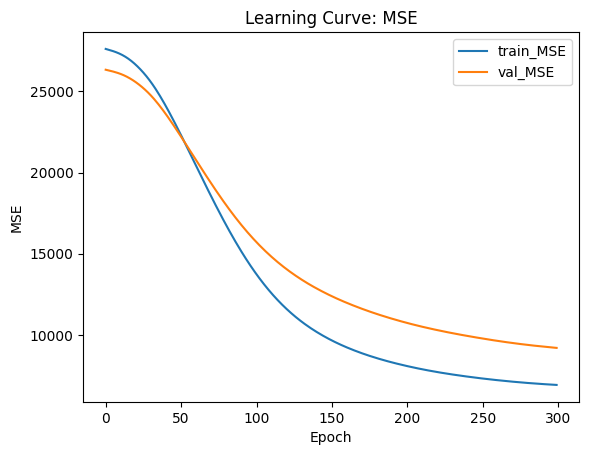

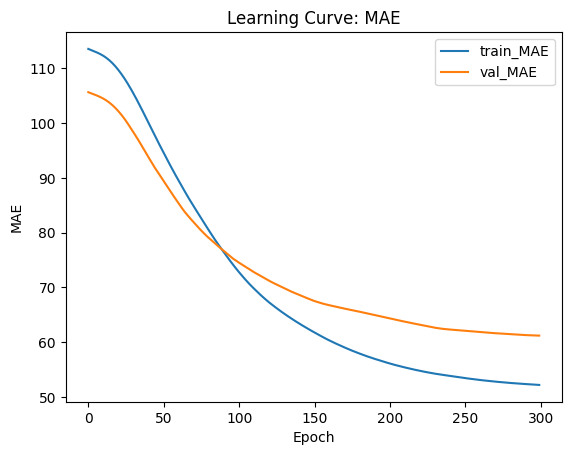

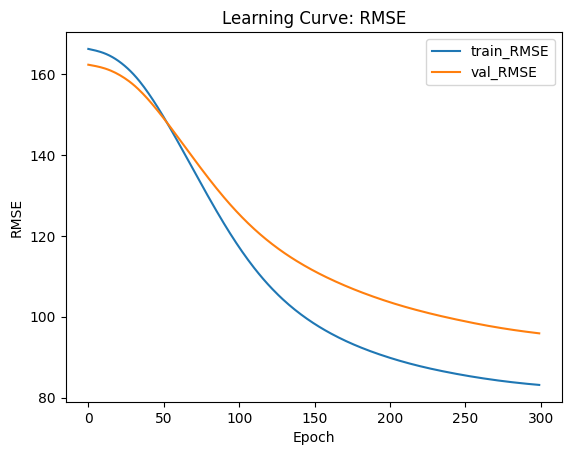

In [188]:
# Learning curves
plt.figure()
plt.plot(hist.history["loss"], label="train_MSE")
plt.plot(hist.history["val_loss"], label="val_MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Learning Curve: MSE"); plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history["mae"], label="train_MAE")
plt.plot(hist.history["val_mae"], label="val_MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("Learning Curve: MAE"); plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history["rmse"], label="train_RMSE")
plt.plot(hist.history["val_rmse"], label="val_RMSE")
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.title("Learning Curve: RMSE"); plt.legend()
plt.show()

In [189]:
# Final metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_regression(y_true, y_pred):
    y_true_arr = np.array(y_true) if np.array(y_true).ndim == 2 else np.array(y_true).reshape(-1, 1)
    y_pred_arr = np.array(y_pred) if np.array(y_pred).ndim == 2 else np.array(y_pred).reshape(-1, 1)
    mae  = mean_absolute_error(y_true_arr, y_pred_arr, multioutput="uniform_average")
    rmse = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr, multioutput="uniform_average"))
    r2   = r2_score(y_true_arr, y_pred_arr, multioutput="uniform_average")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}
    
import pandas as pd
pd.DataFrame({"train": train_res, "val": val_res})

,train,val
MAE,52.364288,61.502487
RMSE,83.252152,96.045855
R2,0.196971,0.092592


The learning curves for MSE, MAE, and RMSE show steady, monotonic declines for both the training and validation sets, indicating that the model was able to learn meaningful patterns without instability or divergence. The validation loss follows the training loss closely, suggesting minimal overfitting and a reasonable level of generalization to unseen data.

However, the relatively low R^2 values suggest that the model explains only a limited portion of the target variance, meaning its predictive power remains modest. The small gap between the training and validation RMSE (approximately 12.8) confirms that the model is not overfitting, but rather slightly underfitting due to its simplicity.

Because this baseline network has only one hidden layer with relatively few neurons, it has limited representational capacity to capture complex, nonlinear relationships among features. The consistent but slow decline of the loss values shows that while optimization works well, the capacity of the model is the main limiting factor.

## b) Deeper Network [1 point]

Construct and evaluate a model with 2 dense layers having a smaller number of neurons (e.g. 16, 8).

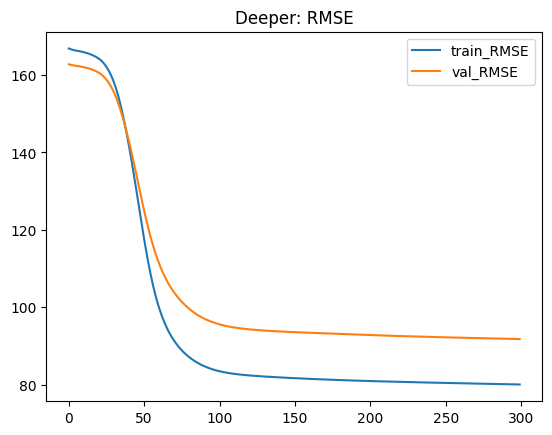

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,train,val
MAE,51.056854,59.737266
RMSE,80.056101,91.796690
R2,0.207373,0.106453


In [190]:
# Deeper model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_deeper(input_dim, target_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(16, activation="relu"),
        layers.Dense(8,  activation="relu"),
        layers.Dense(target_dim, activation="linear"),
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                 keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    return m

deep = build_deeper(input_dim, target_dim)
h_deep = deep.fit(
    X_tr_p, y_tr,
    validation_data=(X_val_p, y_val),
    epochs=300, batch_size=32, verbose=0,
    callbacks=[early],
)

# Learning curves
plt.figure(); plt.plot(h_deep.history["rmse"], label="train_RMSE"); plt.plot(h_deep.history["val_rmse"], label="val_RMSE"); plt.legend(); plt.title("Deeper: RMSE"); plt.show()

# Metrics table
deep_train = evaluate_regression(y_tr,  deep.predict(X_tr_p))
deep_val   = evaluate_regression(y_val, deep.predict(X_val_p))
pd.DataFrame({"train": deep_train, "val": deep_val})


The learning curve for RMSE shows a fast, stable decrease during the first 50 epochs, followed by a gradual convergence. Both training and validation curves follow a similar pattern, which indicates stable learning without divergence or oscillation. The smaller gap (11.74) between them suggests good generalization and minimal overfitting.

Compared with the baseline model, the deeper network achieved slightly lower training and validation errors, as well as improved R^2 values. This means the additional layer helped the network capture more complex feature interactions that the shallow model could not.

## c) Wider Network [1 point]

Construct and evaluate a wider model with more neurons (e.g. 32, 16).

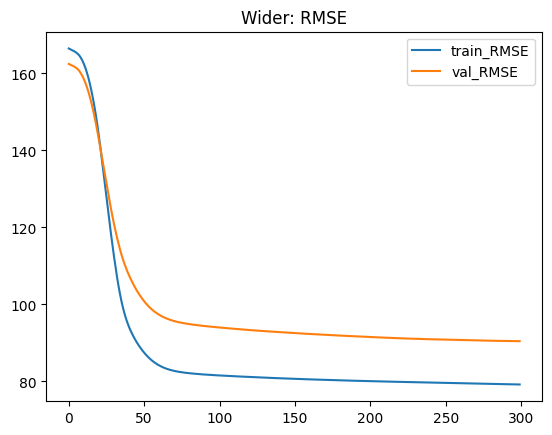

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,train,val
MAE,50.240225,59.039949
RMSE,79.173471,90.446319
R2,0.267744,0.223212


In [191]:
# Wider model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_wider(input_dim, target_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(target_dim, activation="linear"),
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                 keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    return m

wide = build_wider(input_dim, target_dim)
h_wide = wide.fit(
    X_tr_p, y_tr,
    validation_data=(X_val_p, y_val),
    epochs=300, batch_size=32, verbose=0,
    callbacks=[early],
)

# Learning curves
plt.figure(); plt.plot(h_wide.history["rmse"], label="train_RMSE"); plt.plot(h_wide.history["val_rmse"], label="val_RMSE"); plt.legend(); plt.title("Wider: RMSE"); plt.show()

# Metrics table
wide_train = evaluate_regression(y_tr,  wide.predict(X_tr_p))
wide_val   = evaluate_regression(y_val, wide.predict(X_val_p))
pd.DataFrame({"train": wide_train, "val": wide_val})


The learning curve for the wider network shows rapid convergence during the first 50 epochs, followed by a stable, gradual decline. Both training and validation RMSE curves move closely together, which suggests stable learning and good generalization.

Compared with both the baseline and deeper models, the wider network achieved the lowest overall error and the highest R² scores. The generalization gap of roughly 12 points remains small, indicating that the model’s additional neurons improved its representational capacity without introducing overfitting. 

In conclusion, increasing the width allowed the model to capture more complex relationships among features, leading to stronger predictive performance. This suggests that, for this dataset, expanding layer width was more beneficial than adding extra depth.


# Part 2: Hyperparameter Tuning Experiments

In the following experiments, you will evaluate and compare models trained with different hyperparameters. Please follow the specifications given for each model.

## a) Model 1 [2 points]

- 2 Dense layers:
  - The first with 64 neurons using a ReLU activation function.
  - The second with 64 neurons using a ReLU activation function.
- Choose an appropriate output layer and activation.
- Train model with 100 epochs and obtain cross-validated performance (e.g. with 3 cross-folds).
- Plot both loss and mean absolute error (i.e. learning curves) for both training and validation.
- Report MAE from CV with standard deviation.

Fold 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 1 MAE: 51.19
Fold 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 2 MAE: 52.92
Fold 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 3 MAE: 54.74

Cross-validated MAE: 52.95 ± 1.45


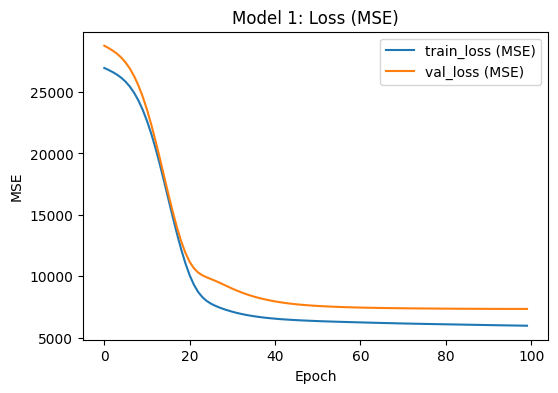

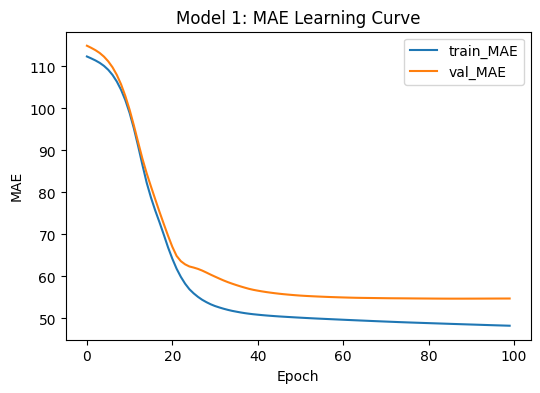

In [192]:
# Model 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim, target_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(target_dim, activation="linear")
    ])
    m.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse",
              metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    return m

# Data preparation
X = X_tr_p
y = np.array(y_tr)
input_dim, target_dim = X.shape[1], (y.shape[1] if y.ndim == 2 else 1)

# Cross-validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)
histories, fold_mae = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/3")
    model = build_model(input_dim, target_dim)
    h = model.fit(X[train_idx], y[train_idx],
                  validation_data=(X[val_idx], y[val_idx]),
                  epochs=100, batch_size=32, verbose=0)
    histories.append(h)
    val_pred = model.predict(X[val_idx])
    mae = np.mean(np.abs(y[val_idx] - val_pred))
    fold_mae.append(mae)
    print(f"Fold {fold+1} MAE: {mae:.2f}")

mean_mae = np.mean(fold_mae)
std_mae = np.std(fold_mae)
print(f"\nCross-validated MAE: {mean_mae:.2f} ± {std_mae:.2f}")

# Training curves
plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["loss"], label="train_loss (MSE)")
plt.plot(histories[-1].history["val_loss"], label="val_loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Model 1: Loss (MSE)"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["mae"], label="train_MAE")
plt.plot(histories[-1].history["val_mae"], label="val_MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("Model 1: MAE Learning Curve"); plt.legend(); plt.show()


The model 1 trained smoothly, showing a rapid drop in loss during the first 20 epochs followed by steady convergence.
Its cross-validated MAE = 52.95 ± 1.45, indicating consistent generalization and minimal overfitting.
This configuration demonstrated that two moderately sized ReLU layers with Adam optimization can effectively capture nonlinear patterns while maintaining stability.
Overall, it serves as a strong, balanced baseline.

## b) Model 2 [2 points]

- 2 Dense layers:
  - The first with 128 neurons using a ReLU activation function.
  - The second with 64 neurons using a ReLU activation function.
- Choose an appropriate output layer and activation.
- Train model with 100 epochs and obtain cross-validated performance (e.g. with 3 cross-folds).
- Plot both loss and mean absolute error (i.e. learning curves) for both training and validation.
- Report MAE from CV with standard deviation.

Fold 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 1 MAE: 50.90
Fold 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 2 MAE: 53.29
Fold 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3 MAE: 54.86

Cross-validated MAE: 53.01 ± 1.63


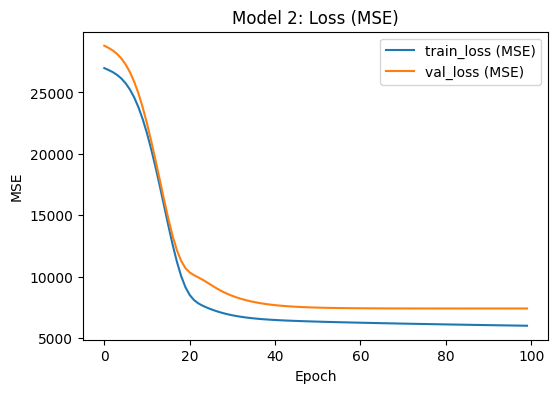

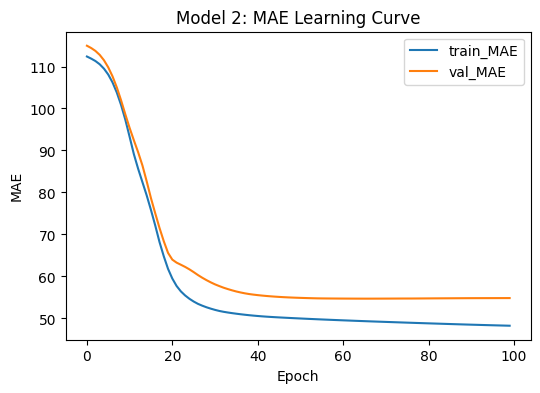

In [193]:
# Model 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model_2(input_dim, target_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(target_dim, activation="linear")
    ])
    m.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse",
              metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    return m

# Data and CV
X = X_tr_p
y = np.array(y_tr)
input_dim, target_dim = X.shape[1], (y.shape[1] if y.ndim == 2 else 1)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
histories, fold_mae = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/3")
    model = build_model_2(input_dim, target_dim)
    h = model.fit(X[train_idx], y[train_idx],
                  validation_data=(X[val_idx], y[val_idx]),
                  epochs=100, batch_size=32, verbose=0)
    histories.append(h)
    val_pred = model.predict(X[val_idx])
    mae = np.mean(np.abs(y[val_idx] - val_pred))
    fold_mae.append(mae)
    print(f"Fold {fold+1} MAE: {mae:.2f}")

mean_mae = np.mean(fold_mae)
std_mae = np.std(fold_mae)
print(f"\nCross-validated MAE: {mean_mae:.2f} ± {std_mae:.2f}")

# Training curves
plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["loss"], label="train_loss (MSE)")
plt.plot(histories[-1].history["val_loss"], label="val_loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Model 2: Loss (MSE)"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["mae"], label="train_MAE")
plt.plot(histories[-1].history["val_mae"], label="val_MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("Model 2: MAE Learning Curve"); plt.legend(); plt.show()


Increasing the first layer to 128 neurons slightly boosted representational capacity without introducing instability.
Both training and validation curves were smooth and nearly overlapping, confirming good generalization.
The model reached MAE = 53.01 ± 1.63, which is close to Model 1.
This suggests that beyond a certain width, additional neurons offer diminishing returns for this dataset.

## c) Model 3 [2 points]

- Same as Model 2, but use tanh activation functions instead of relu.

Fold 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 1 MAE: 72.76
Fold 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 2 MAE: 83.97
Fold 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 3 MAE: 82.72

Cross-validated MAE (Model 3): 79.82 ± 5.02


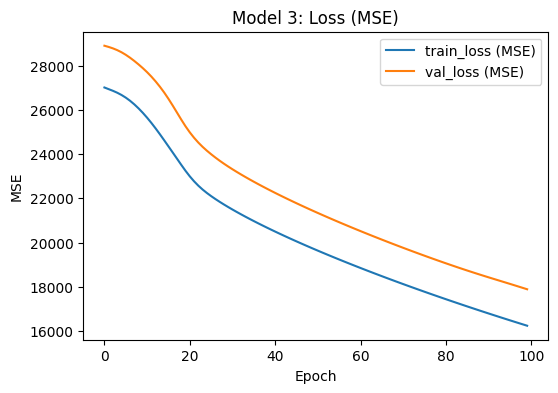

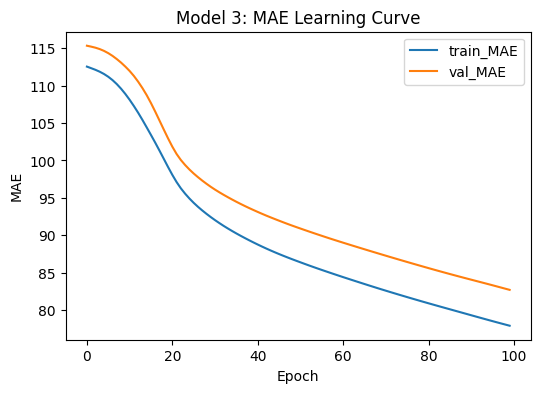

In [194]:
# Model 3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model_3(input_dim, target_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="tanh"),
        layers.Dense(64,  activation="tanh"),
        layers.Dense(target_dim, activation="linear"),
    ])
    m.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse",
              metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    return m

# Data and CV
X = X_tr_p
y = np.array(y_tr)
input_dim, target_dim = X.shape[1], (y.shape[1] if y.ndim == 2 else 1)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
histories, fold_mae = [], []

for fold, (tr, va) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/3")
    model = build_model_3(input_dim, target_dim)
    h = model.fit(X[tr], y[tr],
                  validation_data=(X[va], y[va]),
                  epochs=100, batch_size=32, verbose=0)
    histories.append(h)
    mae = np.mean(np.abs(y[va] - model.predict(X[va])))
    fold_mae.append(mae)
    print(f"Fold {fold+1} MAE: {mae:.2f}")

m3_mean, m3_std = float(np.mean(fold_mae)), float(np.std(fold_mae))
print(f"\nCross-validated MAE (Model 3): {m3_mean:.2f} ± {m3_std:.2f}")

# Training curves from last fold
plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["loss"], label="train_loss (MSE)")
plt.plot(histories[-1].history["val_loss"], label="val_loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Model 3: Loss (MSE)"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["mae"], label="train_MAE")
plt.plot(histories[-1].history["val_mae"], label="val_MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("Model 3: MAE Learning Curve"); plt.legend(); plt.show()

# Store for comparison
if "cv_results" not in globals(): cv_results = {}
cv_results["Model 3 (128×64, tanh, Adam)"] = (m3_mean, m3_std)


Switching to tanh activations resulted in slower early convergence and noticeably higher error (MAE = 79.82 ± 5.02).
The performance drop reflects tanh’s tendency to saturate and produce smaller gradients, which can slow learning and limit the model’s ability to capture large-scale variations.
While training remained stable, the overall predictive accuracy was clearly inferior to the ReLU-based networks.

## d) Model 4 [2 points]

- Same as Model 2, but use the rmsprop optimizer when training.

Fold 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 1 MAE: 51.63
Fold 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 2 MAE: 53.43
Fold 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 3 MAE: 54.14

Cross-validated MAE (Model 4): 53.07 ± 1.06


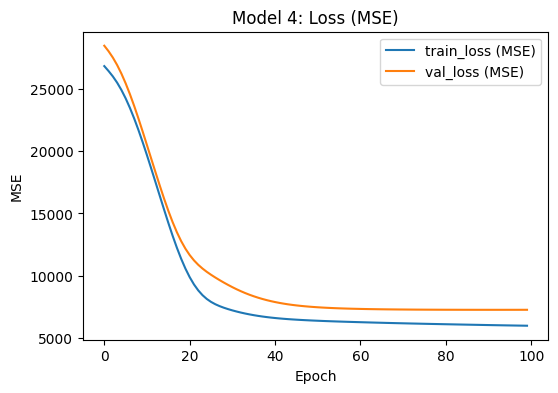

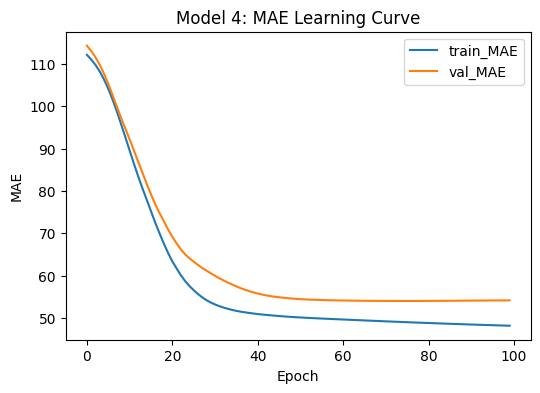

In [196]:
# Model 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model_4(input_dim, target_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64,  activation="relu"),
        layers.Dense(target_dim, activation="linear"),
    ])
    m.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss="mse",
              metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    return m

# Data and CV
X = X_tr_p
y = np.array(y_tr)
input_dim, target_dim = X.shape[1], (y.shape[1] if y.ndim == 2 else 1)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
histories, fold_mae = [], []

for fold, (tr, va) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/3")
    model = build_model_4(input_dim, target_dim)
    h = model.fit(X[tr], y[tr],
                  validation_data=(X[va], y[va]),
                  epochs=100, batch_size=32, verbose=0)
    histories.append(h)
    mae = np.mean(np.abs(y[va] - model.predict(X[va])))
    fold_mae.append(mae)
    print(f"Fold {fold+1} MAE: {mae:.2f}")

m4_mean, m4_std = float(np.mean(fold_mae)), float(np.std(fold_mae))
print(f"\nCross-validated MAE (Model 4): {m4_mean:.2f} ± {m4_std:.2f}")

# Plot curves from last fold
plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["loss"], label="train_loss (MSE)")
plt.plot(histories[-1].history["val_loss"], label="val_loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Model 4: Loss (MSE)"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(histories[-1].history["mae"], label="train_MAE")
plt.plot(histories[-1].history["val_mae"], label="val_MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("Model 4: MAE Learning Curve"); plt.legend(); plt.show()

# Store for comparison
if "cv_results" not in globals(): cv_results = {}
cv_results["Model 4 (128×64, ReLU, RMSprop)"] = (m4_mean, m4_std)


Replacing Adam with RMSprop produced a similar learning trajectory and reliable convergence.
Its cross-validated performance (MAE = 53.07 ± 1.06) was close to Models 1 and 2, with slightly lower variability across folds.
This indicates that RMSprop can perform comparably well on this problem, though Adam remains marginally more efficient for faster early convergence.

## e) Model Comparison [1 point]

Which model performed best? Offer your thoughts on why the particular choice of hyperparameters led to improved performance for this model.

Model 1:
How it trained: Fast, stable drop in MSE/MAE, then a smooth plateau; validation tracked training.
Why it worked: Two ReLU layers give enough capacity to learn non-linear structure while Adam stabilizes updates.
Result: MAE = 52.95 ± 1.45 — strong accuracy with minimal overfitting; an excellent, efficient baseline.

Model 2:
How it trained: Nearly identical curves to Model 1; no instability.
Why the change: Wider first layer increases capacity, but the task appears already well-served by 64 units.
Result: MAE = 53.01 ± 1.63 — effectively tied with Model 1; extra width gave diminishing returns.

Model 3:
How it trained: Slower early convergence; higher and noisier validation MAE.
Why the drop: tanh saturates, leading to smaller gradients and harder optimization compared to ReLU.
Result: MAE = 79.82 ± 5.02 — notably worse; activation choice limited learning.

Model 4:
How it trained: Smooth, stable; similar shape to Adam runs.
Why so similar: Optimizer tweaks change update dynamics but not representational capacity.
Result: MAE = 53.07 ± 1.06 — comparable to Models 1–2; slightly lower variance.

To compare, Model 1 with the lowest MAE and simplest architecture is the best.
Capacity is sufficient to model the signal; more width didn’t help (Model 2), tanh hurt (Model 3), and RMSprop gave similar results (Model 4). This supports the bias/variance view: once capacity is adequate, optimizer/activation changes have smaller effects than architecture.